# TAMSAT Pertinence Analysis

- ¿Como hicieron con IMERG para calcular la lluvia total diaría?
- ¿Cuales son las unidades de los distintos parametros?
- Revisar como hicieron el tema de la lluvia accumulada tanto en superficie como en los últimos 7 días (smoothing)
- ¿Cuales son las no linealidades existentes dentro del modelo hidrológico?¿Es necesariamente un modelo no lineal mejor?

### To Do
Crear archivos con los datos del benchmark
Sacar gráficas con los distintos benchamarks
Estudiar los LSTM
Fichero para facilitar la lectura de las LLM

> T

In [ ]:
#| default_exp tamsat

In [ ]:
#| hide
from nbdev.showdoc import *

/home/i/Documentos/1_Proyectos/ombs_senegal/.venv/lib/python3.12/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib


In [ ]:
#| export
from pathlib import Path
import xarray as xr
import geopandas as gpd

from ombs_senegal.region import get_region_mask

In [ ]:
DATA = Path("../../data")

In [ ]:
#| skip_export

tamsat = xr.open_dataset(DATA/"01-tamsatDaily.v3.1-20100101-20250531-20250603_-16.85_-6.05_10.15_18.95.nc")

In [ ]:
#| skip_export
roi_gdf = gpd.read_file(DATA/"point_ajustement/sub_poly.shp")
mask = get_region_mask(tamsat, roi_gdf)

<matplotlib.collections.QuadMesh>

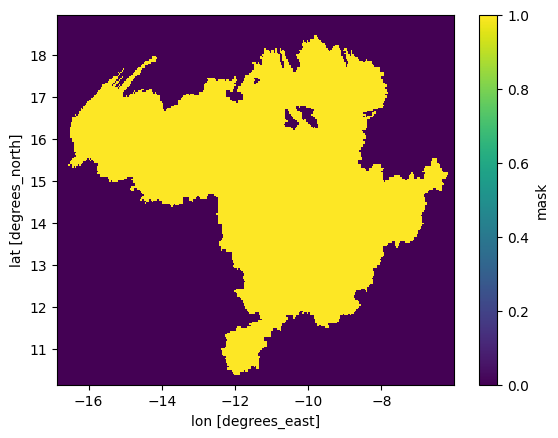

In [ ]:
#| skip_export
mask.plot()

In [ ]:
#| skip_export
roi_tamsat = tamsat.where(mask)

In [ ]:
#| skip_export
roi_tamsat = roi_tamsat.sel(time=slice(None, "2024-12-31"))

<matplotlib.collections.QuadMesh>

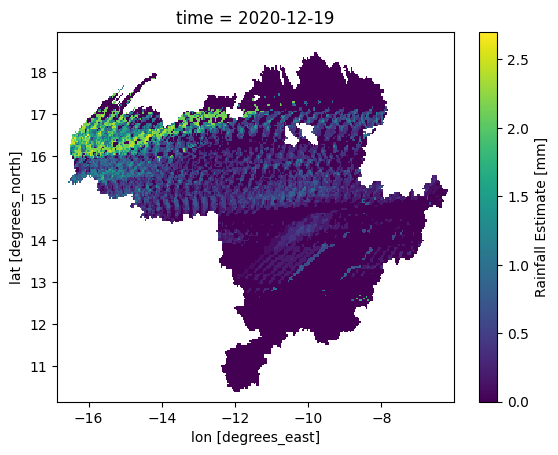

In [ ]:
#| skip_export
roi_tamsat.isel(time=4005)["rfe"].plot()

[<matplotlib.lines.Line2D>]

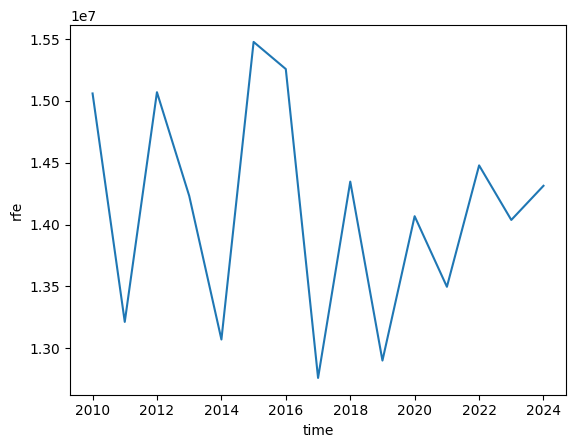

In [ ]:
#| skip_export
daily_total = roi_tamsat.sum(["lat", "lon"])
yearly_total = daily_total.resample(time="YS").sum()
yearly_total["rfe"].plot()

In [ ]:
import hvplot.pandas
import pandas as pd

In [ ]:
#| skip_export
df = pd.read_csv(
    DATA/'data_cumul.csv', 
    sep=';', 
    usecols=['time', 'débit_insitu'], 
    index_col='time',
    converters={"time": pd.to_datetime}
    )

In [ ]:
#| skip_export
combined_df = pd.merge(df, daily_total["rfe"].to_dataframe(), left_index=True, right_index=True)
combined_df.head()

,débit_insitu,rfe
time,,
2010-01-01,84.410004,0.000000
2010-01-02,81.690002,0.000000
2010-01-03,78.720001,0.000000
2010-01-04,76.400002,114.599998
2010-01-05,74.910004,0.000000


In [ ]:
#| skip_export
yearly_df = combined_df.resample("YS").sum()

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Débit vs Rainfall')

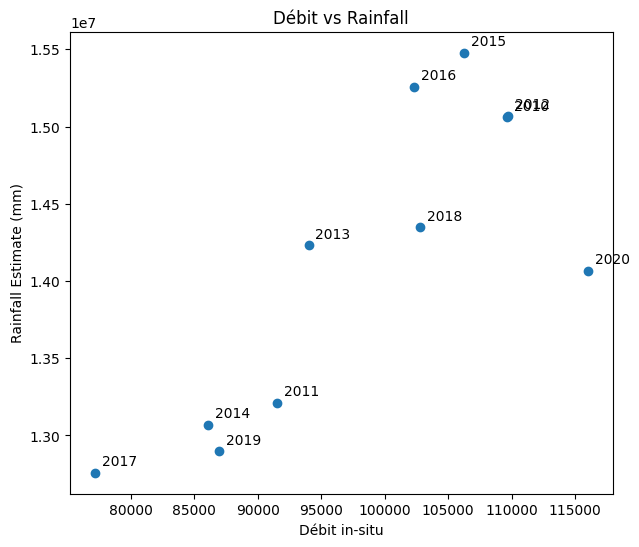

In [ ]:
#| skip_export
plt.figure(figsize=(7,6))
plt.scatter(yearly_df['débit_insitu'], yearly_df['rfe'])

# Add year labels to each point
for idx, row in yearly_df.iterrows():
    plt.annotate(idx.year, 
                (row['débit_insitu'], row['rfe']),
                xytext=(5,5), 
                textcoords='offset points')

plt.xlabel('Débit in-situ')
plt.ylabel('Rainfall Estimate (mm)')
plt.title('Débit vs Rainfall')

In [ ]:
#| skip_export
from ombs_senegal.benchmark_model import normalize

In [ ]:
#| export
def smooth(df, window=7, missing_values=0):
    smoothed_df = df.copy()
    smoothed_df = smoothed_df.rolling(window=window).sum()
    return smoothed_df.fillna(missing_values)



In [ ]:
#| skip_export
processed_df = combined_df.copy()
processed_df["rfe"] = smooth(combined_df["rfe"], window=7)
normalized_df = normalize(processed_df)

normalized_df.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [time]   (value)

## Model benchmark with TAMSAT

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from ombs_senegal.benchmark_model import FeatureGenerator, SimpleRegressionModel

In [ ]:
#| skip_export
df = pd.read_csv(
    DATA/'data_cumul.csv', 
    sep=';', 
    usecols=['time', 'P_cumul_7j', 'débit_insitu', 'débit_mgb'], 
    index_col='time',
    converters={"time": pd.to_datetime}
    )

In [ ]:
#| skip_export
df["rfe"] = smooth(combined_df["rfe"], window=7)
normalized_df = normalize(df[["P_cumul_7j", "débit_mgb", "rfe"]])
normalized_df["débit_insitu"] = df["débit_insitu"]

In [ ]:
#| skip_export
train_mask = df.index < '2019-01-01'
x_col, y_col = ['débit_mgb','rfe'], ['débit_insitu']
train = normalized_df[train_mask]
valid = normalized_df[~train_mask]

In [ ]:
#| skip_export

predictions = []
scores = []
for degree in range(1, 4):
    for window in range(10, 61, 10):
        feature_generator = FeatureGenerator(window, degree)        
        train_x, train_y = feature_generator.generate(train, x_col, y_col)
        valid_x, valid_y = feature_generator.generate(valid, x_col, y_col)

        model = SimpleRegressionModel()
        model.fit(train_x, train_y)
        pred = model.predict(valid_x)
        predictions.append({'degree': degree, 'window': window, 'time': valid_x.index.values, 'prediction': pred.values,})

        mse = round(mean_squared_error(valid_y, pred), 1)
        mae = round(mean_absolute_error(valid_y, pred), 1)
        print(f"Degree: {degree}, Window: {window}, MSE: {mse}, MAE: {mae}")
        scores.append({'degree': degree, 'window': window, 'mse': mse, 'mae': mae})


Degree: 1, Window: 10, MSE: 42519.1, MAE: 126.1
Degree: 1, Window: 20, MSE: 36589.5, MAE: 116.3
Degree: 1, Window: 30, MSE: 29807.0, MAE: 98.8
Degree: 1, Window: 40, MSE: 24825.9, MAE: 91.4
Degree: 1, Window: 50, MSE: 22861.5, MAE: 89.4
Degree: 1, Window: 60, MSE: 23964.0, MAE: 91.3
Degree: 2, Window: 10, MSE: 31809.4, MAE: 105.0
Degree: 2, Window: 20, MSE: 25621.8, MAE: 88.9
Degree: 2, Window: 30, MSE: 23538.9, MAE: 80.8
Degree: 2, Window: 40, MSE: 22099.3, MAE: 80.0
Degree: 2, Window: 50, MSE: 21224.4, MAE: 77.6
Degree: 2, Window: 60, MSE: 21185.4, MAE: 75.7
Degree: 3, Window: 10, MSE: 32319.0, MAE: 106.5
Degree: 3, Window: 20, MSE: 34477.0, MAE: 99.3
Degree: 3, Window: 30, MSE: 28720.6, MAE: 89.3
Degree: 3, Window: 40, MSE: 24699.7, MAE: 81.4
Degree: 3, Window: 50, MSE: 27507.5, MAE: 86.2
Degree: 3, Window: 60, MSE: 42419.2, MAE: 107.5



Degree: 1, Window: 50, MSE: 19955.6, MAE: 83.0

In [ ]:
#| skip_export
obs_ds= valid[y_col].to_xarray()

predictions = pd.DataFrame(predictions).explode(['prediction', 'time'])
predictions = predictions.set_index(['degree', 'window', 'time']).sort_index()
predictions_ds = predictions.to_xarray()

scores = pd.DataFrame(scores).set_index(['degree', 'window']).sort_index()
scores_ds = scores.to_xarray()

results_ds = predictions_ds.merge(scores_ds)
results_ds = results_ds.merge(obs_ds)

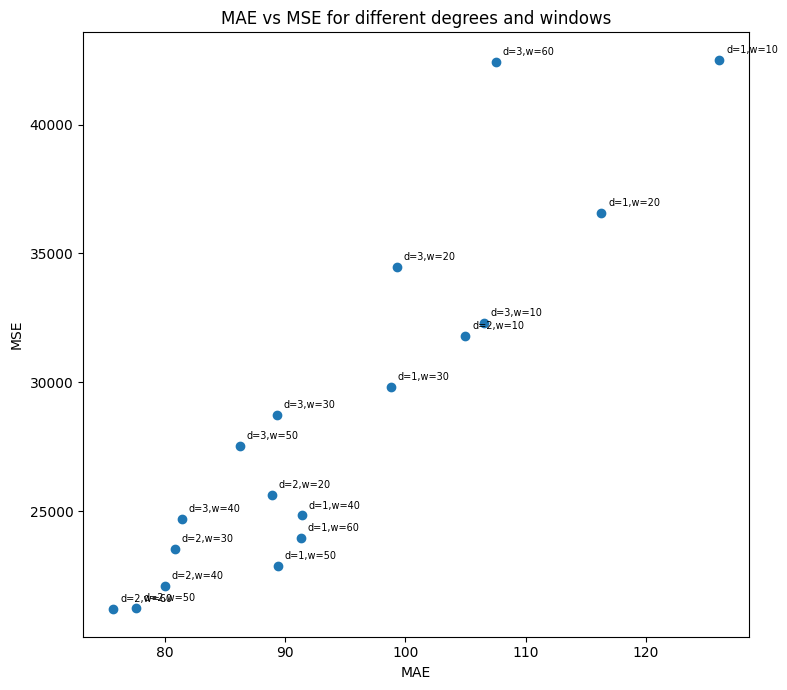

In [ ]:
#| skip_export
df = results_ds[["mae", "mse"]].to_dataframe()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 7))

# Create scatter plot
ax.scatter(df['mae'], df['mse'])

# Add labels for each point
for idx, row in df.iterrows():
    ax.annotate(f'd={idx[0]},w={idx[1]}', 
                (row['mae'], row['mse']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=7)

ax.set_xlabel('MAE')
ax.set_ylabel('MSE') 
ax.set_title('MAE vs MSE for different degrees and windows')

plt.tight_layout()
plt.show()

<Axes: xlabel='time'>

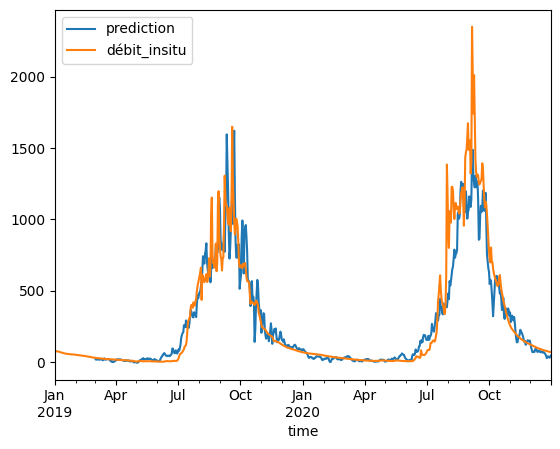

In [ ]:
#| skip_export
results_ds.sel(degree=2, window=60, drop=True)[["prediction", "débit_insitu"]].to_dataframe().plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()